In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import utils
import skutils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

seed = 47

# Use ggplot style
plt.style.use('ggplot')

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [35]:
big = train.append(test)
big.shape

big.species = big.species.astype('category')
big.species = big.species.cat.codes

# big = pd.get_dummies(big, sparse=True)

In [36]:
def transform(data):
    ID = data.id
    X = data.drop(['species', 'id'], axis=1)
    y = data['species']
    return ID, X, y

ID, X, y = transform(big)

In [37]:
def addZeroColumn(df, colName):
    df.loc[df[colName] < 0.01, colName + '_is_small'] = 1
    df[colName + '_is_small'].fillna(0, inplace=True)

def addZeroColumns(df, colBaseName):
    for n in range(1,65):
        addZeroColumn(df, colBaseName + str(n))
        
addZeroColumns(X, 'margin')
addZeroColumns(X, 'texture')

In [101]:
sss = StratifiedShuffleSplit(19, test_size=0.3, random_state=seed)

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, auc, make_scorer, average_precision_score, f1_score
from sklearn.pipeline import Pipeline

classifiers = {
    "LR": { "f": Pipeline([
                ('scaling', StandardScaler()),
                ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
            ]) },
    "RF": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) }
}   

measures = {
    'pre': precision_score,
    #'avg': average_precision_score,
    'rec': recall_score,
    'acc': accuracy_score,
    'ck': cohen_kappa_score,
    'f1': f1_score
}

for clf in classifiers.keys(): 
    c = classifiers[clf]   
    for meas in measures.keys():
        c[meas] = []

for train_index, test_index in sss.split(X, y):
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
            
    for clf in classifiers.keys():                    
        c = classifiers[clf]    
        c["f"].fit(X_train, y_train)
        y_pred = c["f"].predict(X_test)
        
        for meas in measures.keys():
            m = measures[meas]
            
            if (meas != 'ck' and meas != 'acc'):
                score = m(y_test, y_pred, average='micro')
            else:
                score = m(y_test, y_pred)
                        
            c[meas].append(score);

In [105]:
classifiers

{'LR': {'acc': [0.5,
   0.52731092436974791,
   0.49159663865546216,
   0.48949579831932771,
   0.48319327731092437,
   0.51260504201680668,
   0.52521008403361347,
   0.50420168067226889,
   0.51680672268907568,
   0.51050420168067223,
   0.47268907563025209,
   0.49789915966386555,
   0.48529411764705882,
   0.47899159663865548,
   0.49579831932773111,
   0.48109243697478993,
   0.49369747899159666,
   0.50420168067226889,
   0.47058823529411764],
  'ck': [0.39289618657692227,
   0.4249726177437021,
   0.37622111031689298,
   0.38992383805565534,
   0.37602046253863375,
   0.40875896776956833,
   0.4341797984473289,
   0.40138548438665655,
   0.42363173078947913,
   0.40954875529717416,
   0.36866690621631326,
   0.38976977707211369,
   0.37855696472343603,
   0.37035693712530138,
   0.38837134596851919,
   0.38160358502871805,
   0.39606629182723685,
   0.40362277292900972,
   0.35106359957585842],
  'f': Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std

In [110]:
results = pd.DataFrame(columns=measures.keys())

# Evaluate each model in classifiers
for model in classifiers.keys():
    results.loc[model] = [measures[measure](y_test, np.mean(classifiers[model][measure])) for measure in measures.keys()]

results

TypeError: Singleton array 0.43730650154798761 cannot be considered a valid collection.

NameError: name 'results' is not defined

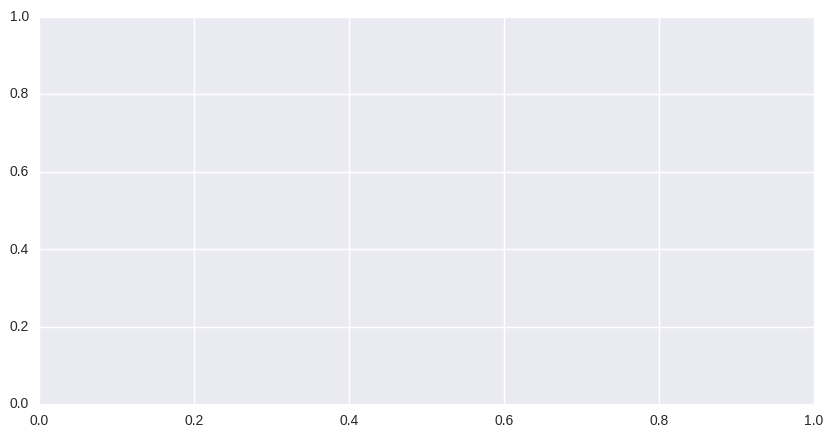

In [106]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(results.shape[0])
width = 0.2
l = ax.plot(ind, results, "-o")
plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.25, ind[-1]+.25])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()

In [ ]:
X = StandardScaler().fit(X).transform(X)

In [ ]:
big.columns

In [ ]:
X[]